In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import *
from keras_lr_finder import *
import collections

/usr/lib64/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
x_train = np.array(pd.read_feather('Data/pvec_all.feather'))

In [3]:
lbl = np.squeeze(pd.read_feather('Data/lbl_all.feather'))

In [4]:
loss_wgt = pd.read_feather('LOSS_WGT_SQRT.feather')

In [5]:
itol = pd.read_feather('Data/52SubCodes.feather')['lbl']
ltoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itol)})

In [6]:
lbl = [ltoi[lbl[i]] for i in range(len(lbl))]

In [7]:
model = None
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=104))
model.add(Dense(64, activation='relu'))
model.add(Dense(52, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
y_train = to_categorical(lbl, 52)

In [9]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               13440     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 52)                3380      
Total params: 25,076
Trainable params: 25,076
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
lr_finder = LRFinder(model)

In [11]:
lr_finder.find(x_train, y_train, start_lr=0.0001, end_lr=1, batch_size=1024, epochs=5)

Epoch 1/5
2179014/2179014 [==============================] - 35s 16us/step - loss: 1.1765 - acc: 0.7624
Epoch 2/5
2179014/2179014 [==============================] - 42s 19us/step - loss: 0.5394 - acc: 0.8577
Epoch 3/5
2179014/2179014 [==============================] - 42s 19us/step - loss: 0.5211 - acc: 0.8548
Epoch 4/5
2089984/2179014 [===========================>..] - ETA: 1s - loss: 0.6855 - acc: 0.8379

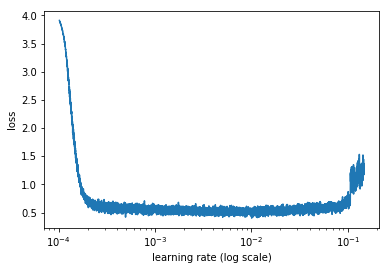

In [12]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [13]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None)

In [14]:
history = model.fit(x_train, y_train,
                    validation_split=.2,
                    epochs=100,
                    batch_size=1024,
                    class_weight=loss_wgt,
                    callbacks=[early_stop] )

Train on 1743211 samples, validate on 435803 samples
Epoch 1/100
1743211/1743211 [==============================] - 30s 17us/step - loss: 0.6181 - acc: 0.8453 - val_loss: 0.5140 - val_acc: 0.8645
Epoch 2/100
1743211/1743211 [==============================] - 31s 18us/step - loss: 0.5298 - acc: 0.8568 - val_loss: 0.4920 - val_acc: 0.8650
Epoch 3/100
1743211/1743211 [==============================] - 29s 17us/step - loss: 0.5132 - acc: 0.8572 - val_loss: 0.4790 - val_acc: 0.8664
Epoch 4/100
1743211/1743211 [==============================] - 31s 18us/step - loss: 0.5031 - acc: 0.8574 - val_loss: 0.4717 - val_acc: 0.8660
Epoch 5/100
1743211/1743211 [==============================] - 30s 17us/step - loss: 0.4969 - acc: 0.8576 - val_loss: 0.4694 - val_acc: 0.8656
Epoch 6/100
1743211/1743211 [==============================] - 29s 16us/step - loss: 0.4924 - acc: 0.8576 - val_loss: 0.4653 - val_acc: 0.8656
Epoch 7/100
1743211/1743211 [==============================] - 29s 16us/step - loss: 0.48

In [15]:
predictions = model.predict(x_train, batch_size=1024)

In [33]:
np.shape(predictions)

(2179014, 52)

In [17]:
correct = np.array([[np.argmax(predictions[i]) == lbl[i]] for i in range(len(predictions))]).sum()

In [18]:
correct, correct/len(predictions)

(1876003, 0.8609412330531149)

In [25]:
pd.DataFrame(predictions, columns=itol.values.astype('str')).to_feather('Result Diagnostic/all_prob.feather')

In [44]:
# Getting top 3 predictions
all_top3 = [[itol[p] for p in np.argsort(-predictions[y])[range(3)]] for y in range(len(predictions))]
all_top3 = pd.DataFrame(np.squeeze(all_top3), columns=np.array(['1st', '2nd', '3rd']))

In [46]:
all_top3.to_feather('Result Diagnostic/top3.feather')

In [68]:
top3_p = [np.sort(-predictions[y])[range(3)] for y in range(len(predictions))]
top3_p = pd.DataFrame(top3_p, columns=np.array(['p_1st', 'p_2nd', 'p_3rd']))

TypeError: bad operand type for unary -: 'NoneType'

In [70]:
top3_p = -top3_p
top3_p.to_feather('Result Diagnostic/top3_prob.feather')